In [12]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import shap
import matplotlib.pyplot as plt
import seaborn as sns

df = sns.load_dataset('titanic')
X=df.drop(['survived','deck','embark_town','alive','who','adult_male'], axis=1)
y=df['survived']

In [4]:
X.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,alone
0,3,male,22.0,1,0,7.2500,S,Third,False
1,1,female,38.0,1,0,71.2833,C,First,False
2,3,female,26.0,0,0,7.9250,S,Third,True
3,1,female,35.0,1,0,53.1000,S,First,False
4,3,male,35.0,0,0,8.0500,S,Third,True


In [15]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
ranfor = RandomForestClassifier(n_estimators=100, random_state=42)
grad = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

In [16]:
numeric_features = ['age','fare']
categorical_features = ['sex','embarked','class','alone']

num_preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_preproc, numeric_features),
    ('cat',cat_preproc, categorical_features)
])


models = {
    'Logistic Regression':Pipeline([
        ('preprocessor', preprocessor),
        ('clf', logreg)
    ]),
    'Random Forest':Pipeline([
        ('preprocessor', preprocessor),
        ('clf', ranfor)
    ]),
    'Gradient Boosting':Pipeline([
        ('preprocessor', preprocessor),
        ('clf', grad)
    ]),
    'XG Boosting':Pipeline([
        ('preprocessor', preprocessor),
        ('clf', xgb)
    ]),
}

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

results = {}

for name, model in models.items():
  scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
  results[name] = {
      'accuracy': np.mean(scores['test_accuracy']),
      'f1': np.mean(scores['test_f1']),
      'roc_auc': np.mean(scores['test_roc_auc']),
  }

evaluation_table = pd.DataFrame(results).T
pd.DataFrame(results).T

,accuracy,f1,roc_auc
Logistic Regression,0.795750,0.725233,0.848179
Random Forest,0.819308,0.756710,0.873195
Gradient Boosting,0.826031,0.755476,0.867852
XG Boosting,0.820400,0.759624,0.871289


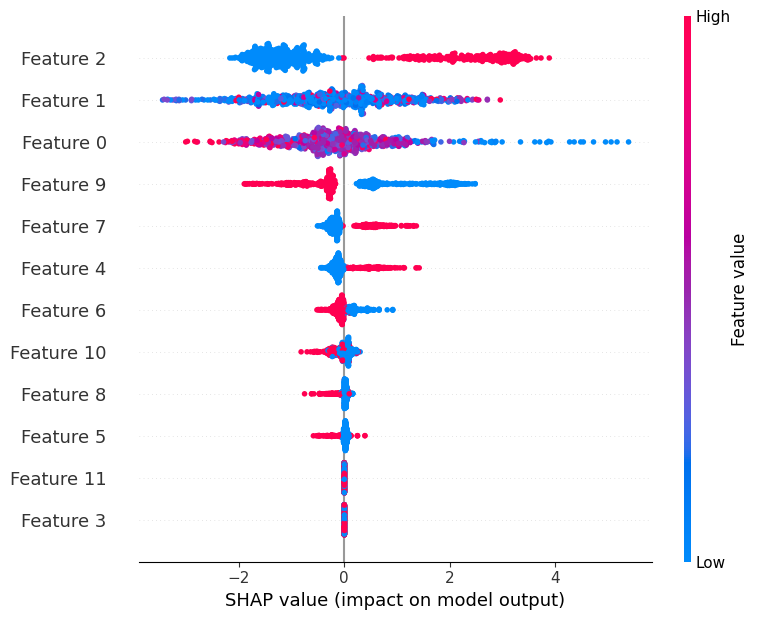

In [31]:
# Train XGBoost separately for SHAP (no pipeline)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
X_processed = preprocessor.fit_transform(X)
xgb_model.fit(X_processed, y)

# SHAP explanation
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_processed)

# Summary plot
shap.summary_plot(shap_values, X_processed)

In [50]:
print("Model Selection Report:")
best_model = evaluation_table['roc_auc'].idxmax()

for name, row in evaluation_table.iterrows():
    print("Model: ",name, "(Best model)" if name == best_model else "")
    print(f"  Accuracy : {row['accuracy']:.4f}")
    print(f"  F1-score : {row['f1']:.4f}")
    print(f"  ROC-AUC  : {row['roc_auc']:.4f}")
    print()

Model Selection Report:
Model:  Logistic Regression 
  Accuracy : 0.7958
  F1-score : 0.7252
  ROC-AUC  : 0.8482

Model:  Random Forest (Best model)
  Accuracy : 0.8193
  F1-score : 0.7567
  ROC-AUC  : 0.8732

Model:  Gradient Boosting 
  Accuracy : 0.8260
  F1-score : 0.7555
  ROC-AUC  : 0.8679

Model:  XG Boosting 
  Accuracy : 0.8204
  F1-score : 0.7596
  ROC-AUC  : 0.8713

